In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [2]:
df = pd.read_csv("winequality-red.csv")

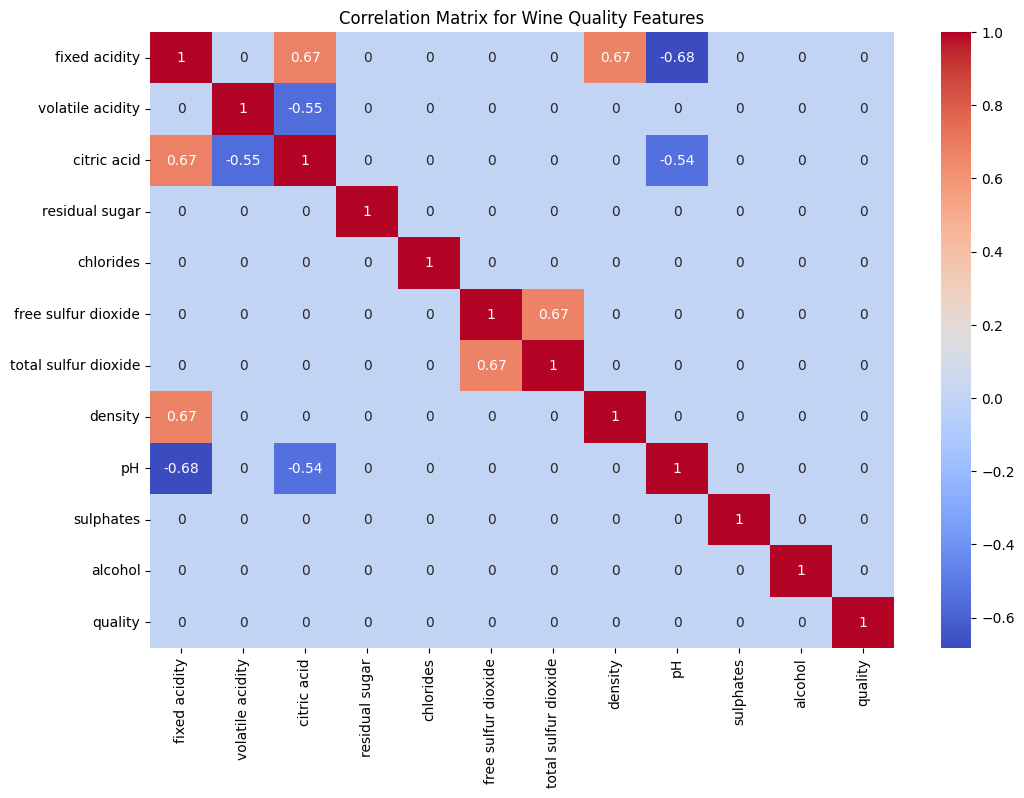

[('fixed acidity', 'citric acid'), ('fixed acidity', 'density'), ('fixed acidity', 'pH'), ('volatile acidity', 'citric acid'), ('citric acid', 'pH'), ('free sulfur dioxide', 'total sulfur dioxide')]


In [3]:
correlation_matrix = df.corr()
high_corr_list = []

quality_corr = correlation_matrix['quality'].iloc[:-1].copy()

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i].iloc[j]) < 0.5:
            correlation_matrix.iloc[i].iloc[j] = 0
        else:
            if i<j:
                high_corr_list.append((correlation_matrix.index[i], correlation_matrix.columns[j]))

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Wine Quality Features')
plt.show()
print(high_corr_list)

In [108]:
df.quality

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

<Axes: xlabel='quality', ylabel='count'>

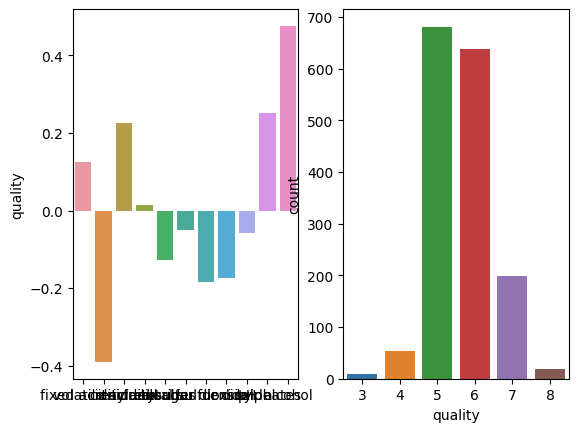

In [4]:
plt.subplot(1, 2, 1)
sns.barplot(y = quality_corr, x = quality_corr.index)
plt.subplot(1, 2, 2)
sns.countplot(df, x = "quality")

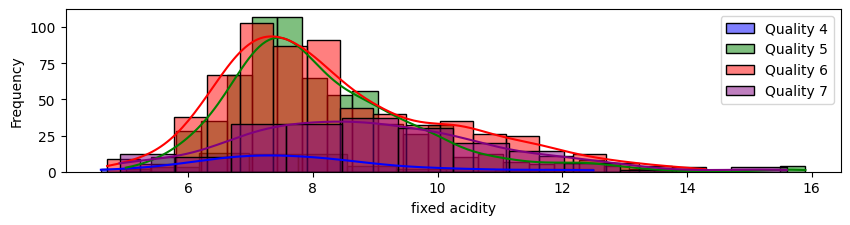

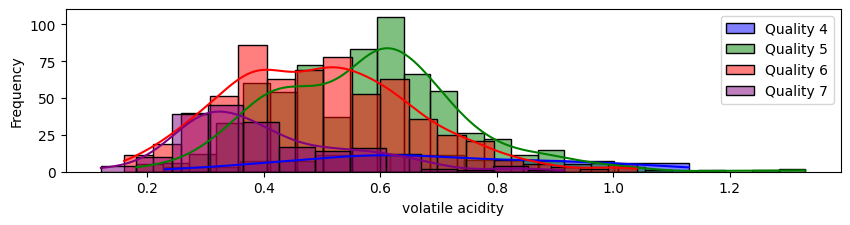

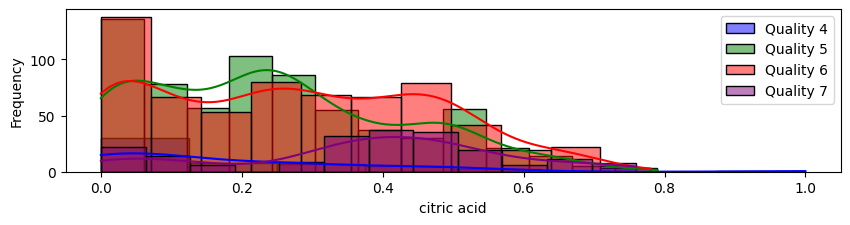

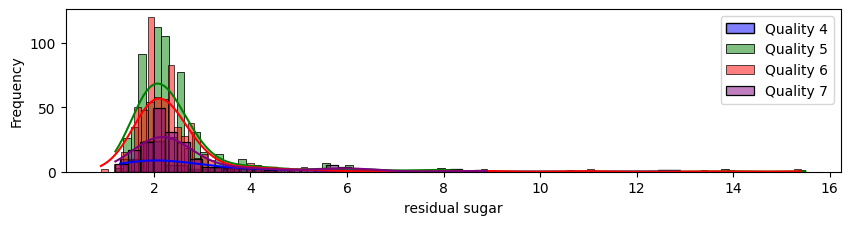

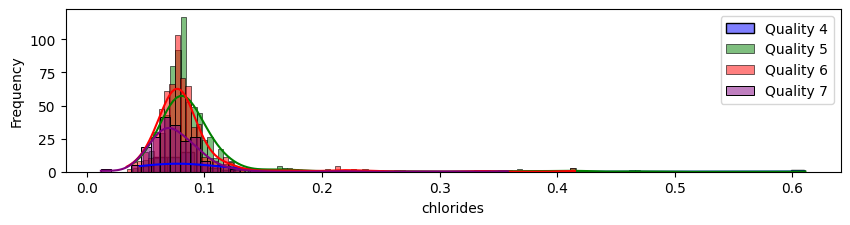

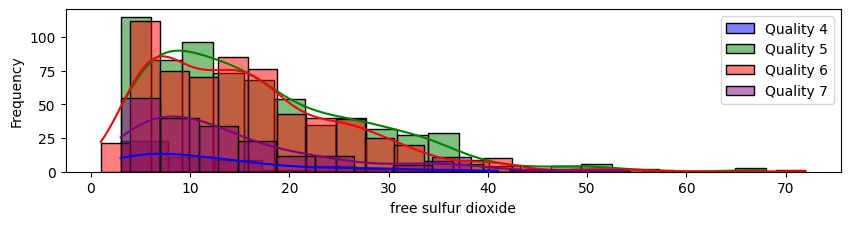

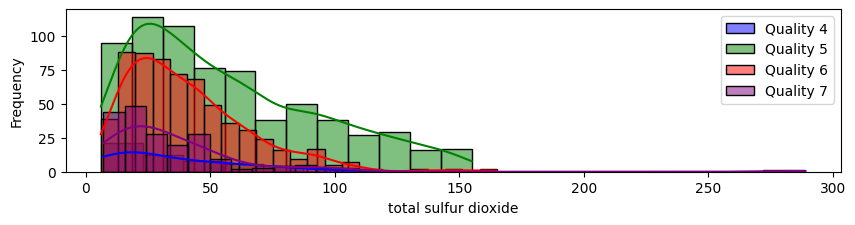

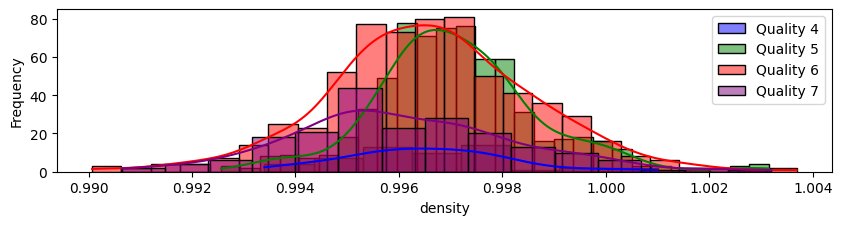

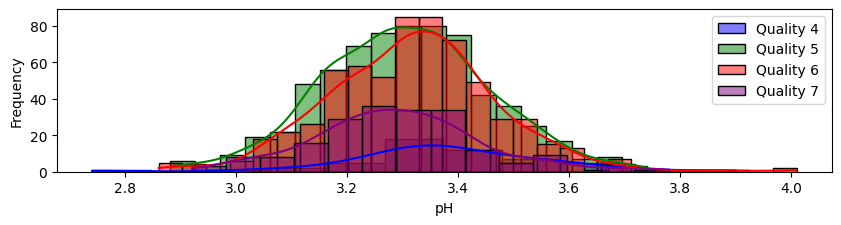

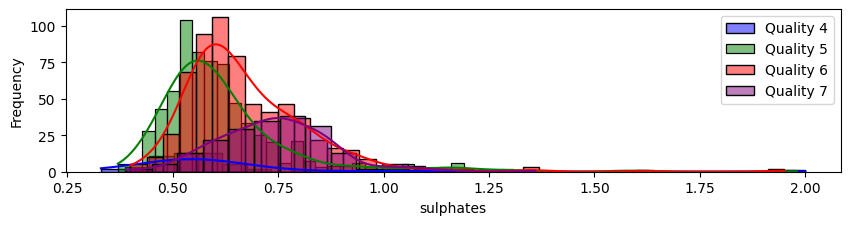

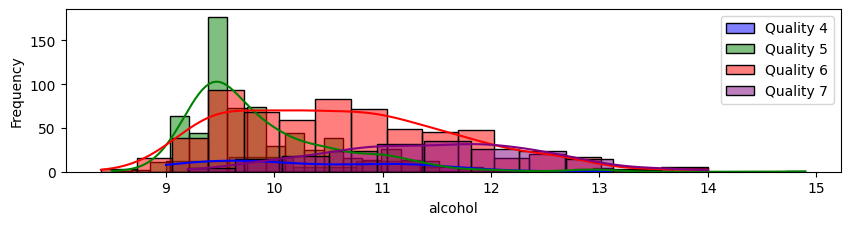

In [375]:
for i in range(11):
    var = df.columns[i]
    plt.figure(figsize=(10, 30))  # Set the size of the plot
    plt.subplot(12, 1, i+1)
    sns.histplot(df[df.quality == 4][var], label='Quality 4', kde=True, color='blue', alpha=0.5)
    sns.histplot(df[df.quality == 5][var], label='Quality 5', kde=True, color='green', alpha=0.5)
    sns.histplot(df[df.quality == 6][var], label='Quality 6', kde=True, color='red', alpha=0.5)
    sns.histplot(df[df.quality == 7][var], label='Quality 7', kde=True, color='purple', alpha=0.5)

    plt.xlabel(f'{var}')
    plt.ylabel('Frequency')
    plt.legend()  # Add a legend to distinguish between the histograms

    plt.show()

In [5]:
# Preparing the dataset
label_encoder = LabelEncoder()

df = pd.read_csv("winequality-red.csv")
df = df.query('quality != 3 and quality != 8')

X = df.drop('quality', axis=1).values
y = df['quality'].values
y = label_encoder.fit_transform(df['quality'])


# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the neural network
class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, size)  # 11 input features
        self.fc2 = nn.Linear(size, size)
        self.fc3 = nn.Linear(size, len(np.unique(y)))
        self.residual = nn.Linear(size, size)  # Residual connection
        self.drop = nn.Dropout(0.7)

    def forward(self, x):
        x = self.drop(torch.relu(self.fc1(x)))

        x = self.drop(torch.relu(self.fc2(x)))

        identity = self.residual(x)
        x = x + identity
        x = self.drop(torch.relu(self.fc2(x)))

        x = self.drop(torch.relu(self.fc2(x)))

        
        x = self.fc3(x)
        return x
    



In [6]:
for size in [16, 32, 64, 128, 256, 1024, 4096]:
    model = Net(size)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training the model
    num_epochs = 1000  # You can adjust this
    training_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.long())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_loss.append(np.log(loss.item()))
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        model.eval()
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            valloss = criterion(val_outputs.squeeze(), val_labels.long())
        val_loss.append(np.log(valloss.item()))

    print(size, val_loss[-1])
# sns.lineplot(training_loss)
# sns.lineplot(val_loss)

16 0.2769178010772323
32 0.16029102670518178
64 0.12005866642160014
128 0.12578101012721915
256 0.02635560008511417
1024 -0.2035558639342411
4096 0.478621519192855


epoch: 499 loss: 0.014325149365672734
epoch: 999 loss: -0.04652258034089695
epoch: 1499 loss: -0.09059258234887835
epoch: 1999 loss: -0.12979647146668385
epoch: 2499 loss: -0.1603151182913088
epoch: 2999 loss: -0.1731694771494377
epoch: 3499 loss: -0.17636169763239523
epoch: 3999 loss: -0.17935441408475153
-0.17123483243159252


<Axes: >

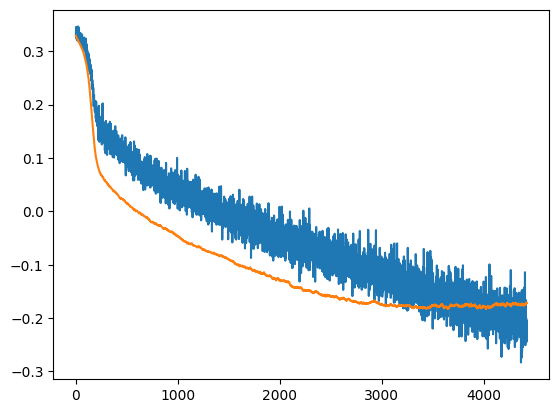

In [27]:
model = Net(1024)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training the model
num_epochs = 10000  # You can adjust this
training_loss = []
val_loss = []
earlystop = 0
min = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_loss.append(np.log(running_loss / len(train_loader)))
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


    model.eval()
    val_running_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        valloss = criterion(val_outputs.squeeze(), val_labels.long())
        val_running_loss += valloss.item()
    val_loss.append(np.log(val_running_loss / len(val_loader)))

    if val_loss[-1] > min:
        earlystop += 1
    else:
        earlystop = 0
        min = val_loss[-1]
    if earlystop >= 400:
        break
    if epoch % 500 == 499:
        print("epoch:", epoch, "loss:", val_loss[-1])


print(val_loss[-1])
sns.lineplot(training_loss)
sns.lineplot(val_loss)

In [28]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
# new_w = torch.Tensor([1, 1, 1.4, 1])

with torch.no_grad():  # Inference without gradient calculation
    correct = 0
    total = 0
    p = []
    o = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        p += predicted
        o += labels

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    

Accuracy of the model on the test set: 55.41%


In [30]:
confusion_matrix(o, p)

array([[ 4,  1,  2,  0],
       [ 7, 35, 18,  1],
       [ 5, 12, 25, 19],
       [ 0,  0,  5, 23]])

In [508]:
def permutation_importance(model, X_val, y_val, metric=accuracy_score):
    # Store the original metric
    baseline_metric = metric(np.argmax(model(X_val).detach().numpy(), 1), y_val.numpy())
    # print(len(np.max(model(X_val).detach().numpy(), 1)), len(y_val.numpy()))
    importance = {}

    for i, column in enumerate(df.columns[:-1]):  # Assuming the last column is the target
        X_val_permuted = X_val.clone().detach()
        X_val_permuted[:, i] = X_val_permuted[:, i][torch.randperm(len(X_val_permuted))]
        
        # Measure performance with the permuted data
        permuted_metric = metric(np.argmax(model(X_val_permuted).detach().numpy(), 1), y_val.numpy())
        
        # The importance is the decrease in model performance
        importance[column] = baseline_metric - permuted_metric

    return importance


<Axes: >

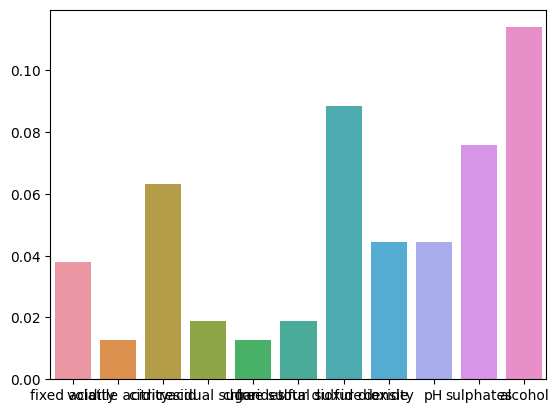

In [509]:
importance = permutation_importance(model, X_val_tensor, y_val_tensor)
sns.barplot(x = list(importance.keys()), y = list(importance.values()))

In [380]:
# Preparing the dataset
label_encoder = LabelEncoder()

df = pd.read_csv("winequality-red.csv")
df = df.query('quality != 3 and quality != 8')
df.quality = df['quality'] == 6

X = df.drop('quality', axis=1).values
y = df['quality'].values
y = label_encoder.fit_transform(df['quality'])


# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the neural network
class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, size)  # 11 input features
        self.fc2 = nn.Linear(size, size)
        self.fc3 = nn.Linear(size, len(np.unique(y)))   # 1 output feature (quality)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.drop(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    



-0.5733063271401894


<Axes: >

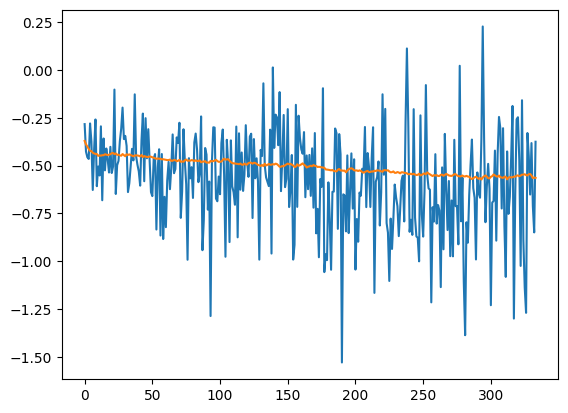

In [381]:
model = Net(256)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 10000  # You can adjust this
training_loss = []
val_loss = []
earlystop = 0
min = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss.append(np.log(loss.item()))
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    model.eval()
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        valloss = criterion(val_outputs.squeeze(), val_labels.long())
    val_loss.append(np.log(valloss.item()))

    if (val_loss[-1] > min):
        earlystop += 1
    else:
        earlystop = 0
        min = val_loss[-1]
    if earlystop >= 40:
        break
    if epoch % 500 == 499:
        print("epoch:", epoch, "loss:", val_loss[-1])


print(min)
sns.lineplot(training_loss)
sns.lineplot(val_loss)

In [382]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
# new_w = torch.Tensor([1, 1, 1.4, 1])

with torch.no_grad():  # Inference without gradient calculation
    correct = 0
    total = 0
    p = []
    o = []
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data , 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        p += predicted
        o += labels

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
    

Accuracy of the model on the test set: 64.33%


In [383]:
confusion_matrix(o, p)

array([[62, 34],
       [22, 39]])

<Axes: >

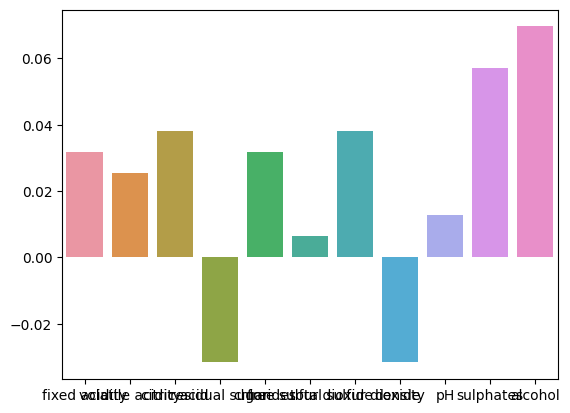

In [439]:
importance = permutation_importance(model, X_val_tensor, y_val_tensor)
sns.barplot(x = list(importance.keys()), y = list(importance.values()))

AttributeError: 'bool' object has no attribute 'all'

In [413]:
np.argmax(model(X_val_tensor).detach().numpy(), 1)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0])